In [1]:
# Handout: https://andrewcumming.github.io/phys512/hw.html

import numpy as np
import matplotlib.pyplot as plt

seed = 42
rng = np.random.default_rng(seed)

## 1) Diffusion-limited aggregation

In [2]:
N = 10_000 # particles
n = 200 # grid
# n = 400

positions = rng.choice(np.arange(n), size=(N,2))

In [3]:
# First just observe how the particles move
# Pick 5 at random to plot their trajectories

T = 2500

to_plot = rng.choice(np.arange(N), size=5, replace=False)
positions_plot = np.array([positions[to_plot,:]]).reshape(5,2,1)

for _ in range(T):
    
    # move
    positions += rng.choice([-1,0,1], size=(N,2))
    
    # apply periodic BC. Modulo operator does exactly what we need
    positions %= n
    
    # save for plot
    positions_plot = np.dstack((positions_plot, positions[to_plot,:]))

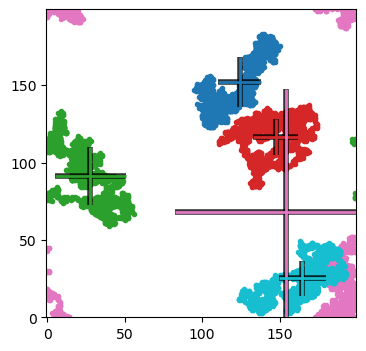

In [4]:
plt.figure(figsize=(4,4))
plt.axis('equal')
plt.xlim([0,n-1])
plt.ylim([0,n-1])
plt.xticks(np.arange(0,n,int(n/4)))
plt.yticks(np.arange(0,n,int(n/4)))

for i in range(5):
    x = positions_plot[i,0,:]
    y = positions_plot[i,1,:]
    plt.plot(x,y,'.', mec=None, zorder=-1)
    
    # Plot std deviation in x and y
    plt.errorbar(np.mean(x), np.mean(y), 
                 yerr=np.std(y), xerr=np.std(x),
                 ecolor=plt.gca().lines[-1].get_color(), lw=2, zorder=10)
    
    # This is just to make the above stand out
    plt.errorbar(np.mean(x), np.mean(y), 
                 yerr=np.std(y), xerr=np.std(x),
                 ecolor='k', lw=4, zorder=9, alpha=0.8)
    
plt.show()

The spread (standard deviation) of the trajectories in x and y, on average, seems to be close-ish to 50 (green is good example, pink is messed up because of the boundary conditions).

This is indeed what we expect for a random walk, moving by steps of 1, over a total time of 2500 ($\sqrt{2500}=50$!)

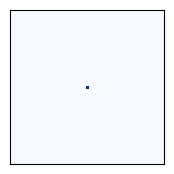

In [5]:
# Now implement the solid array and seed it
solid = np.zeros((n,n))

# single seed
# solid[int(n/2), int(n/2)] = 1

# square seed
solid[int(n/2)-1:int(n/2)+2, int(n/2)-1:int(n/2)+2] = 1

# cross seed
# solid[int(n/2)-4:int(n/2)+5, int(n/2)] = 1
# solid[int(n/2), int(n/2)-4:int(n/2)+5] = 1

# wall seed
# solid[:, int(n/2)] = 1

def plot_solid(ax, solid):
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(solid, vmin=0, vmax=1, cmap="Blues", extent=[0,n,0,n], interpolation='none')
    
fig,ax = plt.subplots(1,1,figsize=(2,2))
plot_solid(ax, solid)
plt.show()

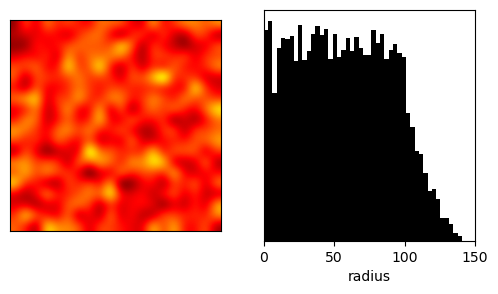

In [6]:
# We'll need these plots later, make the functions now

def plot_2d_density(ax, positions):
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])

    # evaluate the density field of particles
    nbins = 20 # in x&y
    dx = n/nbins # = dy
    density = np.zeros((nbins,nbins))
    
    for i in range(nbins):
        for j in range(nbins):
            xmin,ymin = i*dx, j*dx
            
            # get all the particles which have positions inside the square we are looking at
            # numpy logical_and can do what we need, unfortunately it only accepts 2 arguments
            where = np.logical_and(
                    np.logical_and(positions[:,0]>=xmin, positions[:,0]<xmin+dx), 
                    np.logical_and(positions[:,1]>=ymin, positions[:,1]<ymin+dx)
            )
            
            density[i,j] = sum(where)/len(positions)
            
    ax.imshow(density, cmap="hot", extent=[0,n,0,n], interpolation='bicubic')
    
def plot_radial_hist(ax, positions):
    ax.set_xlabel("radius")
    ax.set_yticks([])
    radius = [((x-n/2)**2+(y-n/2)**2)**0.5 for x,y in positions]
    
    bins = np.linspace(0,150,50)
    counts,_ = np.histogram(radius, bins=bins)
    
    # Normalize by the area of the donut
    counts = np.array(counts) / (np.pi*(bins[1:]**2 - bins[:-1]**2))
    
    ax.bar(bins[:-1], height=counts, width=bins[1]-bins[0], align="edge", color='k')

    ax.set_xlim([0,150])
    ax.set_xticks([0,50,100,150])


fig,axes = plt.subplots(1,2,figsize=(6,3))
plot_2d_density(axes[0], positions)
plot_radial_hist(axes[1], positions)
plt.show()

The density of particles is initially uniform, as expected. There is a cutoff at r=100 because the box is a square, so above 100 we only see the corners.

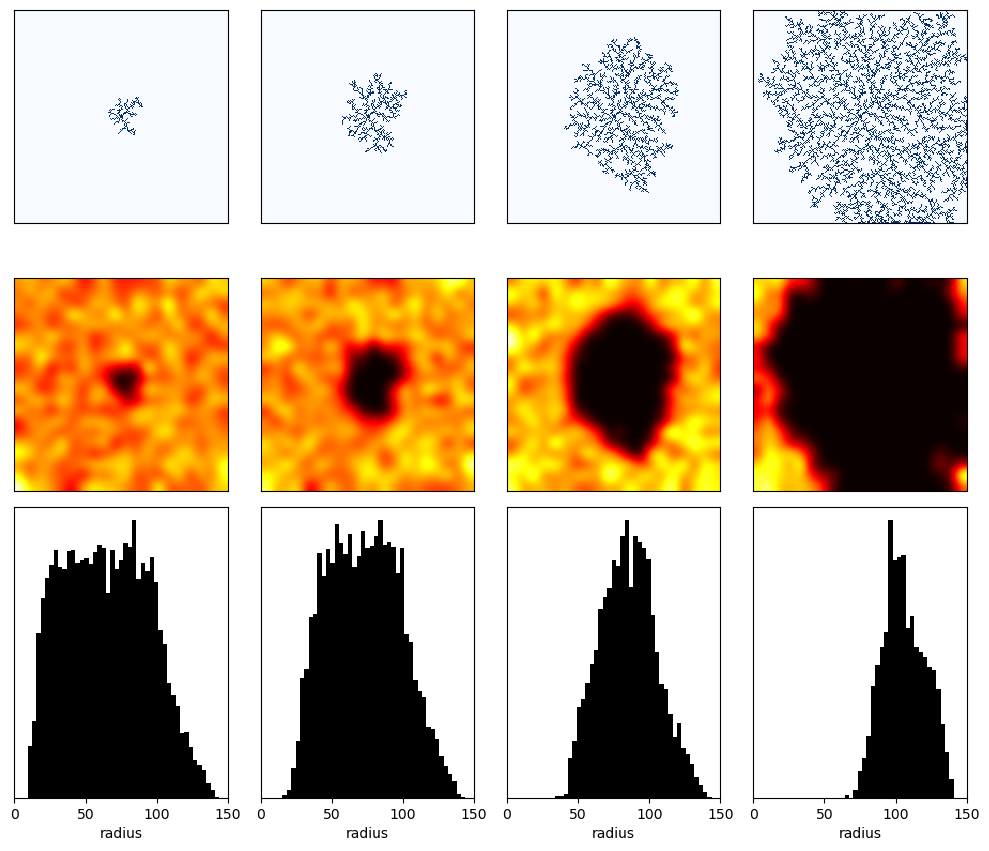

In [7]:
# Evolve
positions = rng.choice(np.arange(n), size=(N,2))

t_plot = [50,100,200,400]

fig,axes = plt.subplots(3, len(t_plot), figsize=(10,9))
fig.subplots_adjust(wspace=0.7)

N_solid = []

for t in range(401):

    # move
    positions += rng.choice([-1,0,1], size=(len(positions),2))

    # apply periodic BC. Modulo operator does exactly what we need
    positions %= n

    # Loop through all particles and check if close to solid
    new_solid = []
    for i in range(len(positions)):
        x,y = positions[i]
        if 1 in solid[x-1:x+2, y-1:y+2]: # 3x3 grid around particle
            new_solid.append(i)

    # Turn into solid
    solid[positions[new_solid][:,0], positions[new_solid][:,1]] = 1
    N_solid.append(np.sum(solid))
    
#     if t%100==0:
#         print(t, N_solid[-1])
#     if N_solid[-1] > 2000:
#         break

    # Remove those particles
    positions = np.delete(positions, new_solid, axis=0)

    # Plotting
    if t in t_plot:
        i = t_plot.index(t)
        plot_solid(axes[0][i], solid)
        plot_2d_density(axes[1][i], positions)
        plot_radial_hist(axes[2][i], positions)


plt.tight_layout()
plt.show()

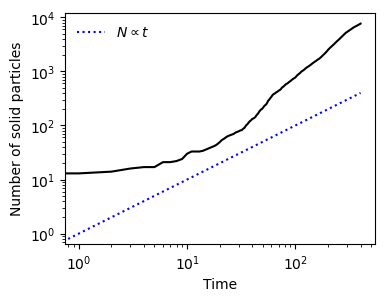

In [8]:
plt.figure(figsize=(4,3))
plt.xlabel("Time")
plt.ylabel("Number of solid particles")
tt = np.arange(401)
plt.loglog(np.arange(401), N_solid, 'k')
plt.loglog(tt, tt, 'b:', label=r"$N\propto t$")
plt.legend(frameon=False)
plt.show()

The number of solids is proportional to the area occupied by the solid, which is the square of a length. Because the distance traveled by the particles goes as $\sqrt{t}$, we would expect the area to increase linearly with $t$. We do start with a linear scaling (after an initial transient where not much happens), but then the growth becomes faster. This might be because the box is too small, so that particles accrete onto the crystal sooner than they otherwise would in a bigger space. The periodic boundary conditions could also play a role.

(addendum: indeed, running the same code with n=400, we do obtain a clear linear scaling after the initial transient).

## 2) Ising model

In [9]:
# The lattice object will hold the data of all the spins,
# and take care of energy and magnetization calculations

class lattice:
    
    def __init__(self,n):
        self.n = n
        self.grid = rng.choice([1,-1], size=(n,n))
        
    def pick_random(self):
        return tuple(rng.choice(np.arange(self.n), 2))
    
    def M(self):
        return np.sum(self.grid)/self.n**2
        
    # define neighbor locations
    def down(self, i, j):  return (i+1)%self.n, j
    def up(self, i, j):    return i-1, j
    def right(self, i, j): return i, (j+1)%self.n
    def left(self, i, j):  return i, j-1
    
    # How does the energy change upon a spin flip at i,j
    def deltaE(self,i,j):
        return 2*self.grid[i,j] * (self.grid[*self.left(i,j)] + self.grid[*self.right(i,j)] + 
                                   self.grid[*self.up(i,j)] + self.grid[*self.down(i,j)])

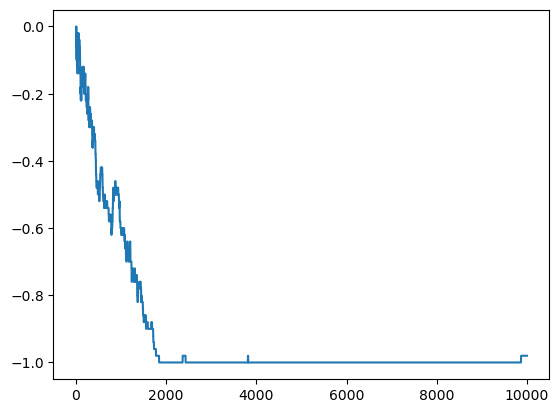

In [10]:
def MCMC(Nspins, Nsteps, kT):
    
    L = lattice(Nspins)
    
    mag = []
    for _ in range(Nsteps):

        # Pick a random spin
        node = L.pick_random()

        # Energy change
        dE = L.deltaE(*node)

        # Decide if we keep this change or not
        u = rng.uniform()
        if u < np.exp(-dE/kT):
            L.grid[*node] *= -1 # apply the spin flip

        mag.append(L.M())
        
    return mag
    
mag = MCMC(10, 10_000, kT=1)
plt.plot(mag)
plt.show()

Burn-in is a couple thousand steps.

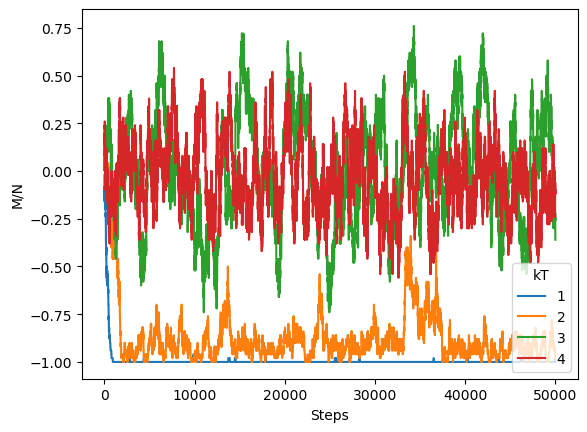

In [11]:
# Try at different T's
plt.figure()

for kT in (1,2,3,4):
    mag = MCMC(10, 50_000, kT)
    plt.plot(mag, label=kT, lw=1.5)

plt.xlabel('Steps')
plt.ylabel('M/N')
plt.legend(title='kT', loc=4)
plt.show()

In [12]:
# Plot the mean magnetization as a function of temperature
# We can ignore the first 10000 as "burn-in"

kTs = np.linspace(1,4,10)
M_mean = []
M_sig = []

for kT in kTs:
    print("%.1f"%kT)
    mag = MCMC(10, 50_000, kT)
    M_mean.append(np.mean(np.abs(mag[10_000:])))
    M_sig.append(np.std(mag[10_000:]))

1.0
1.3
1.7
2.0
2.3
2.7
3.0
3.3
3.7
4.0


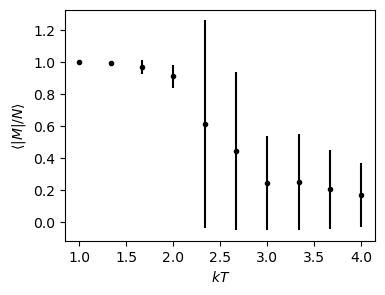

In [13]:
plt.figure(figsize=(4,3))
plt.xlabel(r'$kT$')
plt.ylabel(r'$\langle |M|/N\rangle$')
plt.errorbar(kTs, M_mean, yerr=M_sig, color='k', fmt='.')
plt.show()

We see a second-order phase transition near $kT=2.5$.